# Add Dependencies

In [ ]:
!pip3 install pybullet --upgrade
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 40.2 MB/s eta 0:00:00


# Training

Complete


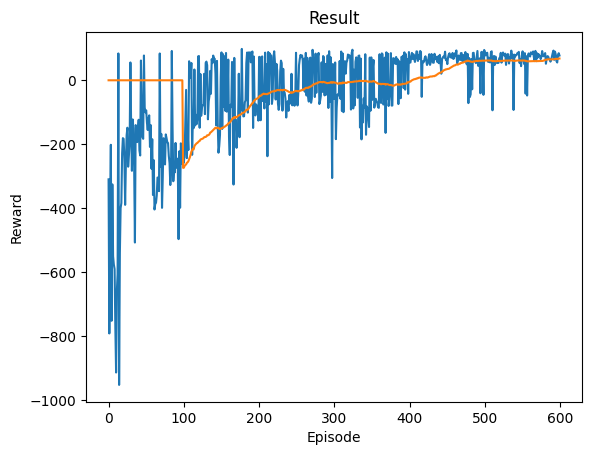

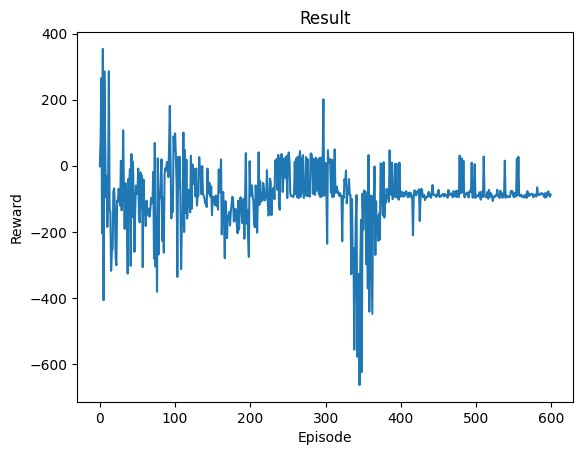

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import pybullet as p
import pybullet_data
import time
import random
import matplotlib
import matplotlib.pyplot as plt
# Initialize PyBullet
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Main simulation loop
# while :
#     keys = p.getKeyboardEvents()
#     force = [0, 0, 0]

#     # WASD/Arrow key controls
#     if p.B3G_UP_ARROW in keys and keys[p.B3G_UP_ARROW] & p.KEY_IS_DOWN:
#         force[1] += force_magnitude  # Forward (W)
#     if p.B3G_DOWN_ARROW in keys and keys[p.B3G_DOWN_ARROW] & p.KEY_IS_DOWN:
#         force[1] -= force_magnitude  # Backward (S)
#     if p.B3G_LEFT_ARROW in keys and keys[p.B3G_LEFT_ARROW] & p.KEY_IS_DOWN:
#         force[0] -= force_magnitude  # Left (A)
#     if p.B3G_RIGHT_ARROW in keys and keys[p.B3G_RIGHT_ARROW] & p.KEY_IS_DOWN:
#         force[0] += force_magnitude  # Right (D)

#     # Apply force to the box
#     p.applyExternalForce(
#         objectUniqueId=box_body,
#         linkIndex=-1,
#         forceObj=force,
#         posObj=p.getBasePositionAndOrientation(box_body)[0],
#         flags=p.WORLD_FRAME,
#     )

#     # Step the simulation
#     p.stepSimulation()
#     time.sleep(time_step)

import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import namedtuple, deque
from itertools import count
import math

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class RobotLocomotionEnv(gym.Env):
    def __init__(self):
        # Action space: 5 discrete actions
        self.action_space = spaces.Discrete(5)

        # Observation space: 8D vector
        # robot pos, adversary pos, robot vel, adversary vel
        low = np.array([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf])
        high = np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        self.robot_observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.defender_observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Environment constants
        self.max_steps = 400
        self.target = np.array([0.0, 0.0])
        self.success_reward = 100
        self.action_cost = -0.1

        # Simulation parameters
        self.force_magnitude = 500  # Magnitude of the applied force
        self.reset()

    def reset(self):
        self.steps = 0
        # Set up the simulation environment
        p.resetSimulation()
        p.setGravity(0, 0, -9.81)

        # Create a simple box (brick)
        start_pos = [0, 0, 0.5]
        start_orientation = [0, 0, 0, 1]  # No rotation (quaternion)
        self.adv_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.5, 0.5, 0.5])
        self.adv_body = p.createMultiBody(baseMass=1,
                                    baseCollisionShapeIndex=self.adv_id,
                                    basePosition=start_pos,
                                    baseOrientation=start_orientation)

        # Set friction for the box
        p.changeDynamics(self.adv_body, -1, lateralFriction=0.5, spinningFriction=0.5, rollingFriction=0.5)

        # Load a plane
        plane_id = p.loadURDF("plane.urdf")

        # Physics engine parameters
        p.setPhysicsEngineParameter(enableConeFriction=1)

        # Create a simple box (brick)
        agent_x = random.uniform(0.5, 10) * np.random.choice([-1, 1])
        agent_y = random.uniform(0.5, 10) * np.random.choice([-1, 1])
        # Create a simple box (brick)
        start_pos = [agent_x, agent_y, 0.5]
        start_orientation = [0, 0, 0, 1]  # No rotation (quaternion)
        self.ag_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.5, 0.5, 0.5])
        self.ag_body = p.createMultiBody(baseMass=1,
                                    baseCollisionShapeIndex=self.ag_id,
                                    basePosition=start_pos,
                                    baseOrientation=start_orientation)

        # Set friction for the box
        p.changeDynamics(self.ag_body, -1, lateralFriction=0.5, spinningFriction=0.5, rollingFriction=0.5)

    def step(self, ag_action, adv_action):
        self.steps += 1
        if self.steps > self.max_steps or self.reached_goal():
            raise ValueError("Max steps reached")
        # Apply action to update accelerations
        def get_action(action):
            linear_acc = np.zeros(2)
            if action == 0:
                # Acc forward move
                linear_acc = np.array([0, self.force_magnitude])
            elif action == 1:
                # Acc backward move
                linear_acc = np.array([0, -self.force_magnitude])
            elif action == 2:
                # Acc left move
                linear_acc = np.array([-self.force_magnitude, 0])
            elif action == 3:
                # Acc right move
                linear_acc = np.array([self.force_magnitude, 0])
            elif action == 4:
                # Do nothing: no acceleration
                pass
            else:
                raise ValueError("Invalid action")
            return [linear_acc[0], linear_acc[1], 0]

        p.applyExternalForce(
            objectUniqueId=self.ag_body,
            linkIndex=-1,
            forceObj=get_action(ag_action),
            posObj=p.getBasePositionAndOrientation(self.ag_body)[0],
            flags=p.WORLD_FRAME,
        )
        p.applyExternalForce(
            objectUniqueId=self.adv_body,
            linkIndex=-1,
            forceObj=get_action(adv_action),
            posObj=p.getBasePositionAndOrientation(self.adv_body)[0],
            flags=p.WORLD_FRAME,
        )
        p.stepSimulation()
        state = self.get_state()
        return state, self.get_agent_reward(), self.get_adversary_reward(), self.reached_goal(), self.steps >= self.max_steps

    def get_state(self):
        ag_pos, ag_orientation = p.getBasePositionAndOrientation(self.ag_body)
        adv_pos, adv_orientation = p.getBasePositionAndOrientation(self.adv_body)
        ag_vel, ag_angular_vel = p.getBaseVelocity(self.ag_body)
        adv_vel, adv_angular_vel = p.getBaseVelocity(self.adv_body)
        return [ag_pos[0], ag_pos[1], ag_vel[0], ag_vel[1], adv_pos[0], adv_pos[1], adv_vel[0], adv_vel[1]]

    def dist_between_entities(self):
        position, orientation = p.getBasePositionAndOrientation(self.ag_body)
        adv_position, adv_orientation = p.getBasePositionAndOrientation(self.adv_body)
        return np.linalg.norm(np.array([position[0], position[1]]) - np.array([adv_position[0], adv_position[1]]))


    def ag_dist_to_target(self):
        position, orientation = p.getBasePositionAndOrientation(self.ag_body)
        return np.linalg.norm(np.array([position[0], position[1]]) - self.target)

    def get_adversary_reward(self):
        if self.reached_goal():
            return -self.success_reward
        return (self.ag_dist_to_target() - (self.dist_between_entities()/2))/16

    def get_agent_reward(self):
        if self.reached_goal():
            return self.success_reward
        else:
            return -self.ag_dist_to_target() / 16

    def reached_goal(self):
        return self.ag_dist_to_target() < 0.5

env = RobotLocomotionEnv()

# print("hi")

# for i in range(10000):
#     env.step(1, 1)
#     time.sleep(0.01)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'ag_action', 'adv_action', 'next_state', 'ag_reward', 'adv_reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128 * 2 #! CHANGEd
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


# Get number of actions from gym action space
n_actions = 5
# Get the number of state observations
env.reset()
state = env.get_state()
n_observations = len(state)

policy_net_ag = DQN(n_observations, n_actions).to(device)
target_net_ag = DQN(n_observations, n_actions).to(device)
target_net_ag.load_state_dict(policy_net_ag.state_dict())
optimizer_ag = optim.AdamW(policy_net_ag.parameters(), lr=LR, amsgrad=True)

policy_net_adv = DQN(n_observations, n_actions).to(device)
target_net_adv = DQN(n_observations, n_actions).to(device)
target_net_adv.load_state_dict(policy_net_adv.state_dict())
optimizer_adv = optim.AdamW(policy_net_adv.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)

steps_done = 0

def select_action(state, agent):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            if agent == "ag":
                return policy_net_ag(state).max(1).indices.view(1, 1)
            else:
                return policy_net_adv(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_rewards_ag = []
episode_rewards_adv = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_rewards_ag, dtype=torch.float)
    durations_t_adv = torch.tensor(episode_rewards_adv, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training Agent...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.figure(2)
    durations_t_adv = torch.tensor(episode_rewards_adv, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training Adversary...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t_adv.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    ag_action_batch = torch.cat(batch.ag_action)
    adv_action_batch = torch.cat(batch.adv_action)
    ag_reward_batch = torch.cat(batch.ag_reward)
    adv_reward_batch = torch.cat(batch.adv_reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    adv_state_action_values = policy_net_adv(state_batch).gather(1, adv_action_batch)
    ag_state_action_values = policy_net_ag(state_batch).gather(1, ag_action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    adv_next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        adv_next_state_values[non_final_mask] = target_net_adv(non_final_next_states).max(1).values
    ag_next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        ag_next_state_values[non_final_mask] = target_net_ag(non_final_next_states).max(1).values
    # Compute the expected Q values
    adv_expected_state_action_values = (adv_next_state_values * GAMMA) + adv_reward_batch
    ag_expected_state_action_values = (ag_next_state_values * GAMMA) + ag_reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    adv_loss = criterion(adv_state_action_values, adv_expected_state_action_values.unsqueeze(1))
    ag_loss = criterion(ag_state_action_values, ag_expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer_adv.zero_grad()
    adv_loss.backward()
    optimizer_adv.step()
    optimizer_ag.zero_grad()
    ag_loss.backward()
    optimizer_ag.step()

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    env.reset()
    state = env.get_state()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    total_ag_reward = 0
    total_adv_reward = 0

    for t in count():
        ag_action = select_action(state, "ag")
        adv_action = select_action(state, "adv")
        observation, ag_reward, adv_reward, terminated, truncated = env.step(ag_action.item(), adv_action.item())
        ag_reward = torch.tensor([ag_reward], device=device)
        adv_reward = torch.tensor([adv_reward], device=device)
        done = terminated or truncated
        total_ag_reward += ag_reward
        total_adv_reward += adv_reward

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, ag_action, adv_action, next_state, ag_reward, adv_reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        ag_target_net_state_dict = target_net_ag.state_dict()
        ag_policy_net_state_dict = policy_net_ag.state_dict()
        for key in ag_policy_net_state_dict:
            ag_target_net_state_dict[key] = ag_policy_net_state_dict[key]*TAU + ag_target_net_state_dict[key]*(1-TAU)
        target_net_ag.load_state_dict(ag_target_net_state_dict)

        adv_target_net_state_dict = target_net_adv.state_dict()
        adv_policy_net_state_dict = policy_net_adv.state_dict()
        for key in adv_policy_net_state_dict:
            adv_target_net_state_dict[key] = adv_policy_net_state_dict[key]*TAU + adv_target_net_state_dict[key]*(1-TAU)
        target_net_adv.load_state_dict(adv_target_net_state_dict)

        if done:
            episode_rewards_ag.append(total_ag_reward)
            episode_rewards_adv.append(total_adv_reward)
            # if (i_episode % 5) == 0:
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Visualization

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def visualize_episode(positions_adj, positions_adv):
    """
    positions_adj: list of (x, y) for the agent at each timestep
    positions_adv: list of (x, y) for the adversary at each timestep
    """
    fig, ax = plt.subplots()

    # Separate (x,y) for easy indexing
    adj_x = [p[0] for p in positions_adj]
    adj_y = [p[1] for p in positions_adj]
    adv_x = [p[0] for p in positions_adv]
    adv_y = [p[1] for p in positions_adv]

    # Create scatter plot objects to update (as line objects that can be updated)
    agent_dot, = ax.plot([], [], 'ro', label='Agent')      # red circle
    adv_dot,   = ax.plot([], [], 'bo', label='Adversary')  # blue circle

    # Optionally set some axis bounds
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_aspect('equal', 'box')
    ax.legend()

    def init():
        agent_dot.set_data([], [])
        adv_dot.set_data([], [])
        return agent_dot, adv_dot

    def update(frame_index):
        # Pass single-point lists instead of scalars
        agent_dot.set_data([adj_x[frame_index]], [adj_y[frame_index]])
        adv_dot.set_data([adv_x[frame_index]], [adv_y[frame_index]])
        return agent_dot, adv_dot

    ani = FuncAnimation(
        fig, update, frames=len(positions_adj),
        init_func=init, blit=True, interval=50  # interval in ms
    )

    plt.close(fig)  # Prevent static figure display in Colab

    return HTML(ani.to_jshtml())


In [ ]:
import matplotlib.pyplot as plt
import torch

episode_position_history_adj = []
episode_position_history_adv = []
episode_rewards_adj = []
episode_rewards_adv = []

env.reset()
state = env.get_state()
done = False
truncated = False

while not (done or truncated):
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # 1) Select actions for both agents
    adj_action = select_action(state_tensor, agent="ag")
    adv_action = select_action(state_tensor, agent="adv")

    # 2) Step the environment
    next_state, adj_reward, adv_reward, done, truncated = env.step(
        adj_action.item(),
        adv_action.item()
    )

    # 3) Extract positions (from next_state, for example)
    adj_x, adj_y = next_state[0], next_state[1]
    adv_x, adv_y = next_state[4], next_state[5]

    # 4) Append positions to history
    episode_position_history_adj.append((adj_x, adj_y))
    episode_position_history_adv.append((adv_x, adv_y))

    # 4.5) Append rewards to history
    episode_rewards_adj.append(adj_reward)
    episode_rewards_adv.append(adv_reward)

    # 5) Update current state
    state = next_state

# After the loop ends, visualize positions
visualize_episode(episode_position_history_adj, episode_position_history_adv)


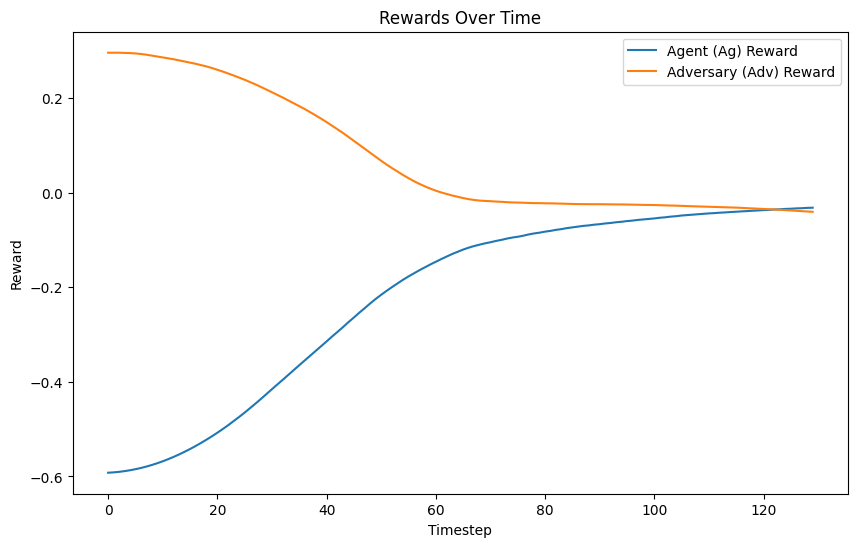

In [ ]:
episode_rewards_adj.pop()
episode_rewards_adv.pop()
# Now plot rewards over time
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards_adj, label='Agent (Ag) Reward')
plt.plot(episode_rewards_adv, label='Adversary (Adv) Reward')
plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.title('Rewards Over Time')
plt.legend()
plt.show()

# Download Weights

In [ ]:
# After you finish training (or at any checkpoint you want):
torch.save(policy_net_ag.state_dict(), "policy_net_agent.pth")
torch.save(policy_net_adv.state_dict(), "policy_net_adversary.pth")

In [ ]:
from google.colab import files
files.download("policy_net_agent.pth")
files.download("policy_net_adversary.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>